In [140]:
from numpy import genfromtxt
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os
import random
from torch.utils.data import TensorDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [142]:
train_x = genfromtxt('train_x.csv', delimiter=',')
test_x = genfromtxt('test_x.csv', delimiter=',')
train_y = genfromtxt('train_y.csv', delimiter=',')

train_y = train_y.T[1]
train_x = np.delete(train_x, 0, 1)
test_x = np.delete(test_x, 0, 1)

CUR_YEAR = 2019

M = {'INUSYR' : 0,'NATVTY':1, 'AGE':2 ,'MAR':3,'SEX':4,'MOVE':5,'SPAN':6,'CITSHP':7,'FAMTYP':8,'FAMREL':9,'RACE':10,'RACEAS':11,'RACEPI':12,'MIL':13,'WAGP':14,'SEMP':15,'SSP':16,'SSIP':17,'PAP':18,'RETP':19,'INTP':20,'OIP':21}
all_data = np.concatenate((train_x, test_x), axis=0) 

# Data cleaning

In [143]:
def clean(d):
    data = copy.deepcopy(d)    
    n, dim = data.shape
    for i in range(dim):
        for j in range(n):
            if i == M['INUSYR']: # Year the person came to the US
                if data[j][i] == -6:
                    data[j][i] = CUR_YEAR - data[j][M['AGE']] ## They were born in US
                birth = CUR_YEAR - data[j][M['AGE']]
                data[j][i] -= birth # At what AGE they came to US
            if i == M['MOVE']:
                birth = CUR_YEAR - data[j][M['AGE']]
                data[j][i] -= birth # At what AGE they move to this address
            if i == M['MIL']:
                if data[j][i] < 0:
                    data[j][i] = 3 # never served
            if i == M['CITSHP']:
                if data[j][i] < 0:
                    data[j][i] = 1 # born in US
            if i == M['WAGP']:
                if data[j][i] < 0:
                    data[j][i] = 0 #
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['SEMP']:
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['SSP']:
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['PAP']:
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['RETP']: # potentially adding if retire or not...
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['INTP']:
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['OIP']:
                data[j][i] = np.log(data[j][i] + 10000)
            if i == M['SSIP']:
                data[j][i] = np.log(data[j][i] + 10000)
            
    return data

In [144]:
train_xc = clean(train_x)
test_xc = clean(test_x)
all_data = clean(all_data).T

In [145]:
# writing
index = np.array([list(range(len(train_xc)))]).T
res = np.concatenate((index,train_xc),axis = 1)
np.savetxt('Data_explore.csv', res, delimiter=',', fmt="%s")

# Data process

In [146]:
def create_type(category, all_d):
    COUNTRY = {}
    counter = 0
    for each in np.unique(all_d[M[category]]):
        COUNTRY[each] = counter
        counter += 1
    return COUNTRY

In [147]:
def process(d, cate_list, all_d, droplist):
    data = copy.deepcopy(d)
    n, dim = d.shape
    dele = []
    for s in droplist:
        dele.append(M[s])
    for category in cate_list:
        CATE = create_type(category, all_d)
        ONE_HOT = np.zeros((n, len(CATE)))
        for j in range(n):
            ONE_HOT[j][CATE[data[j][M[category]]]] = 1
        data = np.concatenate((data, ONE_HOT), axis = 1)
        dele.append(M[category])
    
    return np.delete(data, dele, 1)

In [148]:
C = ['NATVTY','MAR','CITSHP','FAMTYP','FAMREL', 'RACE','RACEAS', 'MIL']
D = ['RACEPI']
train_xcp = process(train_xc,C, all_data,D)
test_xcp = process(test_xc,C, all_data,D)

# Feature selection

In [125]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

X = train_xcp
y = train_y

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(test_xcp)
print(X.shape)

(73740, 226)


In [126]:
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
X_test = model.transform(X_test)
X.shape

(73740, 81)

In [127]:
train_xcp = X
test_xcp = X_test

# Data mining

## (1) Neural network

In [149]:
class BinaryClassifiction(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.to(device)
        self.network = nn.Sequential(
            nn.Linear(dim,512),
            #nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.ReLU(),
            
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Linear(256, 64),
            nn.Dropout(0.5),
            #nn.BatchNorm1d(64),
            nn.Tanh(),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
            
        )
        self.loss_fcn = nn.BCELoss(reduction = 'sum')
        self.losses = []
        self.accuracy = []

    def forward(self, x):
        prediction = self.network(x)
        return (prediction>0.5).float()
    
    def calc_accuracy(self, dl):
        self.eval()
        correct = 0
        with torch.no_grad():
            for x,t in dl:
                x.to(device)
                t.to(device)
                result = self(x)
                correct += torch.sum(result == t.unsqueeze(1)).item()
        return correct/len(dl.dataset)

    def plot(self):
        plt.figure(figsize=(15,8))
        plt.subplot(2,1,1)
        plt.plot(self.losses)
        #plt.yscale('log')
        plt.subplot(2,1,2)
        plt.plot(self.accuracy)
        plt.show()
    
    def learn(self, dl_train, epochs=10, lr = 0.001):
        #optimizer_network = torch.optim.SGD(self.network.parameters(), lr=lr, momentum = 0.9)
        optimizer_network = torch.optim.Adam(self.network.parameters(), lr=lr)
        losses = []
        for epoch in (range(epochs)):
            self.train()
            correct = 0
            for x, t in dl_train:
                x.to(device)
                t.to(device)
                
                y = self.network(x) # forward pass
                loss = self.loss_fcn(y, t.unsqueeze(1))
                
                correct += torch.sum((y>0.5).float() == t.unsqueeze(1)).item()
                
                optimizer_network.zero_grad()
                loss.backward()
                optimizer_network.step()
                
                self.losses.append(loss)
            self.accuracy.append(correct/len(dl_train.dataset))

In [129]:
dim = train_xcp.shape[1]
if dim != test_xcp.shape[1]:
    print('dimension does not match')

## (2) Training

In [130]:
def train_model(train_xcp, train_y, how_many, bs, lr, epoch):
    zero = []
    one = []
    for i in range(len(train_y)):
        if train_y[i] == 1:
            one.append(i)
        else:
            zero.append(i)
    index = np.concatenate([np.random.choice(one, how_many, replace = False), np.random.choice(zero, how_many, replace = False)])
    selected_train = train_xcp[index]
    selected_target = train_y[index]
    tensor_x = torch.Tensor(selected_train) # transform to torch tensor
    tensor_y = torch.Tensor(selected_target)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    dll = DataLoader(my_dataset, batch_size = bs, shuffle=True)
    net = BinaryClassifiction(dim)
    net.learn(dll,epoch,lr)
    return net

# Adjust model

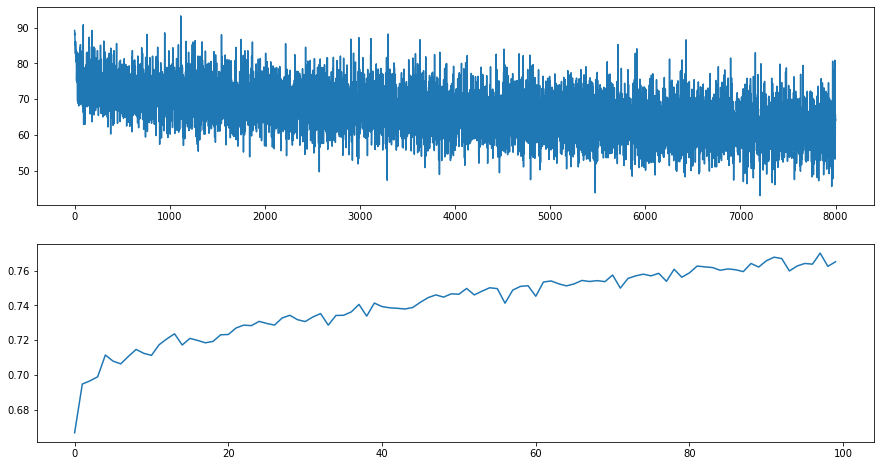

In [139]:
net = train_model(train_xcp, train_y, how_many=40*128, bs=128, lr=0.001, epoch=100)
net.plot()

In [30]:
class voters():
    def __init__(self, train_xcp, train_y, how_many, bs, lr, epoch, how_many_models, first = True):
        self.nets = []
        self.how_many_models = how_many_models
        self.f = first
        for i in tqdm(range(how_many_models)):
            net = train_model(train_xcp, train_y, how_many, bs, lr, epoch)
            self.nets.append(net)
        self.second_voter = None
        
        if first:
            l = self.unsure_list(train_xcp)
            l = np.concatenate((np.random.choice(list(range(len(train_xcp))), len(l), replace = False), l))
            train2 = train_xcp[l]
            target2 = train_y[l] 
            h_many = round(len(l)*0.05)
            self.second_voter = voters(train2, target2, h_many, bs=bs, lr=lr, epoch = epoch, how_many_models=how_many_models, first = False)
        
    
    def validate(self, num, train_xcp, train_y):
        ind = np.random.choice(range(len(train_y)), num, replace = False)
        val_x = torch.Tensor(train_xcp[ind]) # transform to torch tensor
        val_y = train_y[ind]
        res = self.final_vote(val_x)
        return 1-np.sum(np.abs(res - val_y))/len(val_y)
    
    def cross_val(self, num, train_xcp, train_y):
        l = []
        for i in range(10):
            l.append(self.validate(num,train_xcp,train_y))
        print(l)
        print(sum(l)/len(l))
        
    def vote(self, data):
        res = -1
        all_x = torch.Tensor(data)
        for i in range(len(self.nets)):
            if i == 0:
                res = self.nets[i](all_x)
            else:
                res = res + self.nets[i](all_x)
        return res
    
    def final_vote(self, data):
        if self.f:
            res1 = self.vote(data)
            res2 = self.second_voter.vote(data)
            res = []
            for i in range(len(res1)):
                num = res1[i]
                if self.unsure_util(num):
                    num = res2[i]
                res.append(self.zero_one(num))
            return np.array(res)
                
    
    def unsure_list(self,data):
        unsure_list = []
        res = self.vote(data)
        for i in range(len(data)):
            if self.unsure_util(res[i]):
                unsure_list.append(i)
        return unsure_list
    
    def unsure_util(self,num):
        return torch.abs(num - self.how_many_models/2) < self.how_many_models/20
    
    def zero_one(self, num):
        if num > self.how_many_models/2:
            return 1
        return 0

In [31]:
v = voters(train_xcp, train_y, how_many=30*128, bs=128, lr=0.001, epoch=80, how_many_models = 101, first = True)

100%|██████████| 101/101 [00:12<00:00,  8.13it/s]


In [32]:
v.cross_val(2000, train_xcp, train_y)

[0.653, 0.661, 0.6890000000000001, 0.663, 0.687, 0.6595, 0.667, 0.6735, 0.6685, 0.6685]
0.669


In [51]:
res = v.final_vote(test_xcp)

In [ ]:
# writing
index = np.array([list(range(len(test_xcp)))]).T
res = np.concatenate((index,np.array([res]).T),axis = 1)
np.savetxt('res.csv', res, delimiter=',', fmt="%s")